In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Reshape
from imblearn.over_sampling import SMOTE
from keras.layers import LSTM



In [2]:
malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [3]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer
from transformers import AutoTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
# tokenizer_features = 110000
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()
print(f"The longest record is : {max_words} tokens")

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

# Encode
# processed_data['encoded'] = processed_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The longest record is : 171 words
The longest record is : 171 tokens


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [4]:
from keras.layers import Bidirectional, LSTM, Embedding, Concatenate
from keras.layers import Layer
import tensorflow.keras.backend as K
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
    
def build_and_train_model(df, max_features, maximum_length=100, embedding_dim=256, dropout_rate=0.5, lstm_units=60, dense=None, batch_size=16, epochs=20, verbose=0):
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(df['Emotion']), y=df['Emotion'])
    class_weights = dict(enumerate(class_weights))

    # Preprocess features
    X_text = np.asarray(df['padded'].to_list())
    X_sarcasm = df['Sarcasm'].values.reshape(-1, 1)
    X_irony = df['Irony'].values.reshape(-1, 1)
    X_negation = df['Negation'].values.reshape(-1, 1)
    X_sentiment_polarity = OneHotEncoder().fit_transform(df[['Sentiment Polarity']]).toarray()
    # X_sentiment_polarity = OneHotEncoder().fit_transform(df[['Sentiment Polarity']])
    y = pd.get_dummies(df['Emotion']).values

    # Split data
    X_text_train, X_text_val, X_sarcasm_train, X_sarcasm_val, X_irony_train, X_irony_val, X_negation_train, X_negation_val, X_sentiment_polarity_train, X_sentiment_polarity_val, y_train, y_val = train_test_split(
        X_text, X_sarcasm, X_irony, X_negation, X_sentiment_polarity, y, test_size=0.1, random_state=42, stratify=y
    )

    # Define model inputs
    text_input = Input(shape=(maximum_length,), dtype='int32', name='text_input')
    sarcasm_input = Input(shape=(1,), dtype='int32', name='sarcasm_input')
    irony_input = Input(shape=(1,), dtype='int32', name='irony_input')
    negation_input = Input(shape=(1,), dtype='int32', name='negation_input')
    sentiment_polarity_input = Input(shape=(X_sentiment_polarity_train.shape[1],), dtype='int32', name='sentiment_polarity_input')
    inputs = [text_input, sarcasm_input, irony_input, negation_input, sentiment_polarity_input]

    # Text processing
    x = Embedding(input_dim=max_features, output_dim=embedding_dim)(text_input)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Attention()(x)

    # Concatenate additional features
    x = Concatenate()([x, sarcasm_input, irony_input, negation_input, sentiment_polarity_input])
    if dense != None:
        x = Dense(dense, activation='relu')(x)
    outputs = Dense(y.shape[1], activation='softmax')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if verbose != 0:
        model.summary()

    # Train the model
    history = model.fit(
        [X_text_train, X_sarcasm_train, X_irony_train, X_negation_train, X_sentiment_polarity_train], y_train,
        batch_size=batch_size, epochs=epochs,
        validation_data=([X_text_val, X_sarcasm_val, X_irony_val, X_negation_val, X_sentiment_polarity_val], y_val),
        class_weight=class_weights,
        verbose=verbose
    )
    return model, history

In [5]:
embeddings = [64,128,256]
dropouts = [0.2,0.3,0.4,0.5]
lstm_units = [15,30,60,120,240]
dense = [None,8,16,32,64,128,256]
batchs = [32,64,128,256]

best_accuracy = 0
best_params = {}

for e in embeddings:
    for d in dropouts:
        for l in lstm_units:
            for de in dense:
                for b in batchs:
                    print(f"Training with embedding_dim={e}, dropout_rate={d}, lstm_units={l}, dense_layer={de}, batch_size={b}")
                    model, history = build_and_train_model(processed_data, tokenizer_features, maximum_length=100, embedding_dim=e, dropout_rate=d, lstm_units=l, dense=de, batch_size=b, epochs=20)
                    
                    val_accuracy = history.history['val_accuracy'][-1]
                    top_val_accuracy = max(history.history['val_accuracy'])
                    ind = np.argmax(history.history['val_accuracy'])
                    print(f"Value accuracy: {val_accuracy}.  Top accuracy: {top_val_accuracy} at epoch: {ind}")
                    if top_val_accuracy > best_accuracy:
                        best_accuracy = top_val_accuracy
                        best_params = {'embedding_dim': e, 'dropout_rate': d, 'lstm_unit': l, 'dense': de, 'batch_size': b, 'epoch': ind}

print(f"Best validation accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")

Training with embedding_dim=64, dropout_rate=0.2, lstm_units=15, dense_layer=None, batch_size=32
Value accuracy: 0.2410714328289032.  Top accuracy: 0.3125 at epoch: 4
Training with embedding_dim=64, dropout_rate=0.2, lstm_units=15, dense_layer=None, batch_size=64


KeyboardInterrupt: 

In [7]:
# print(f"Best parameters: {best_params}")
best_params = {'embedding_dim': 128, 'dropout_rate': 0.4, 'lstm_unit': 60, 'batch_size': 128, 'epoch': 20, 'dense': 32}
model, history = build_and_train_model(processed_data, tokenizer_features, maximum_length=100, embedding_dim=best_params['embedding_dim'], dropout_rate=best_params['dropout_rate'], lstm_units=best_params['lstm_unit'], dense=best_params['dense'], batch_size=best_params['batch_size'], epochs=best_params['epoch'], verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │  3,906,816 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 128)  │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 100, 120)  │     90,720 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 120)       │        220 │ bidirectional_2[… │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sarcasm_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ irony_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negation_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_polarity… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 126)       │          0 │ attention_2[0][0… │
│ (Concatenate)       │                   │            │ sarcasm_input[0]… │
│                     │                   │            │ irony_input[0][0… │
│                     │                   │            │ negation_input[0… │
│                     │                   │            │ sentiment_polari… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,064 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        264 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,002,084 (15.27 MB)

 Trainable params: 4,002,084 (15.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.2119 - loss: 2.0817 - val_accuracy: 0.2500 - val_loss: 2.0319
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.2252 - loss: 2.0616 - val_accuracy: 0.2857 - val_loss: 2.0133
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.2491 - loss: 2.0435 - val_accuracy: 0.2946 - val_loss: 1.9753
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.3456 - loss: 1.9901 - val_accuracy: 0.3036 - val_loss: 1.9864
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.3338 - loss: 1.9904 - val_accuracy: 0.3304 - val_loss: 1.9718
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.3270 - loss: 1.9649 - val_accuracy: 0.3661 - val_loss: 1.9458
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.3601 - loss: 1.9567 - val_accuracy: 0.3661 - val_loss: 1.9421
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.3427 - loss: 1.8877 - val_accuracy: 0.2946 - val_loss:

Training with embedding_dim=64, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=64, dropout_rate=0.1, batch_size=16
Value accuracy: 0.3571428656578064
Training with embedding_dim=64, dropout_rate=0.1, batch_size=32
Value accuracy: 0.3571428656578064
Training with embedding_dim=64, dropout_rate=0.1, batch_size=64
Value accuracy: 0.3928571343421936
Training with embedding_dim=64, dropout_rate=0.1, batch_size=128
Value accuracy: 0.2678571343421936
Training with embedding_dim=64, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2142857164144516
Training with embedding_dim=64, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2232142835855484
Training with embedding_dim=64, dropout_rate=0.2, batch_size=32
Value accuracy: 0.3839285671710968
Training with embedding_dim=64, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2857142984867096
Training with embedding_dim=64, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2857142984867096
Training with embedding_dim=64, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2946428656578064
Training with embedding_dim=64, dropout_rate=0.3, batch_size=16
Value accuracy: 0.2946428656578064
Training with embedding_dim=64, dropout_rate=0.3, batch_size=32
Value accuracy: 0.375
Training with embedding_dim=64, dropout_rate=0.3, batch_size=64
Value accuracy: 0.3125
Training with embedding_dim=64, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3660714328289032
Training with embedding_dim=64, dropout_rate=0.4, batch_size=8
Value accuracy: 0.3035714328289032
Training with embedding_dim=64, dropout_rate=0.4, batch_size=16
Value accuracy: 0.3125
Training with embedding_dim=64, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2857142984867096
Training with embedding_dim=64, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3214285671710968
Training with embedding_dim=64, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=64, dropout_rate=0.5, batch_size=8
Value accuracy: 0.3303571343421936
Training with embedding_dim=64, dropout_rate=0.5, batch_size=16
Value accuracy: 0.3571428656578064
Training with embedding_dim=64, dropout_rate=0.5, batch_size=32
Value accuracy: 0.2589285671710968
Training with embedding_dim=64, dropout_rate=0.5, batch_size=64
Value accuracy: 0.3839285671710968
Training with embedding_dim=64, dropout_rate=0.5, batch_size=128
Value accuracy: 0.3660714328289032
Training with embedding_dim=128, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2678571343421936
Training with embedding_dim=128, dropout_rate=0.1, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=128, dropout_rate=0.1, batch_size=32
Value accuracy: 0.2946428656578064
Training with embedding_dim=128, dropout_rate=0.1, batch_size=64
Value accuracy: 0.3839285671710968
Training with embedding_dim=128, dropout_rate=0.1, batch_size=128
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=128, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=128, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2678571343421936
Training with embedding_dim=128, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2857142984867096
Training with embedding_dim=128, dropout_rate=0.2, batch_size=128
Value accuracy: 0.3392857015132904
Training with embedding_dim=128, dropout_rate=0.3, batch_size=8
Value accuracy: 0.3125
Training with embedding_dim=128, dropout_rate=0.3, batch_size=16
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.3, batch_size=32
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.3, batch_size=64
Value accuracy: 0.3303571343421936
Training with embedding_dim=128, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=128, dropout_rate=0.4, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=128, dropout_rate=0.4, batch_size=16
Value accuracy: 0.2142857164144516
Training with embedding_dim=128, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2767857015132904
Training with embedding_dim=128, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.4, batch_size=128
Value accuracy: 0.4107142984867096
Training with embedding_dim=128, dropout_rate=0.5, batch_size=8
Value accuracy: 0.3214285671710968
Training with embedding_dim=128, dropout_rate=0.5, batch_size=16
Value accuracy: 0.3125
Training with embedding_dim=128, dropout_rate=0.5, batch_size=32
Value accuracy: 0.3482142984867096
Training with embedding_dim=128, dropout_rate=0.5, batch_size=64
Value accuracy: 0.3571428656578064
Training with embedding_dim=128, dropout_rate=0.5, batch_size=128
Value accuracy: 0.2857142984867096
Training with embedding_dim=256, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=256, dropout_rate=0.1, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=256, dropout_rate=0.1, batch_size=32
Value accuracy: 0.2321428507566452
Training with embedding_dim=256, dropout_rate=0.1, batch_size=64
Value accuracy: 0.2678571343421936
Training with embedding_dim=256, dropout_rate=0.1, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=256, dropout_rate=0.2, batch_size=16
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2410714328289032
Training with embedding_dim=256, dropout_rate=0.2, batch_size=64
Value accuracy: 0.3214285671710968
Training with embedding_dim=256, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2678571343421936
Training with embedding_dim=256, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2857142984867096
Training with embedding_dim=256, dropout_rate=0.3, batch_size=16
Value accuracy: 0.25
Training with embedding_dim=256, dropout_rate=0.3, batch_size=32
Value accuracy: 0.2946428656578064
Training with embedding_dim=256, dropout_rate=0.3, batch_size=64
Value accuracy: 0.3214285671710968
Training with embedding_dim=256, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.4, batch_size=8
Value accuracy: 0.2232142835855484
Training with embedding_dim=256, dropout_rate=0.4, batch_size=16
Value accuracy: 0.2321428507566452
Training with embedding_dim=256, dropout_rate=0.4, batch_size=32
Value accuracy: 0.3571428656578064
Training with embedding_dim=256, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3125
Training with embedding_dim=256, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3303571343421936
Training with embedding_dim=256, dropout_rate=0.5, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=256, dropout_rate=0.5, batch_size=16
Value accuracy: 0.2589285671710968
Training with embedding_dim=256, dropout_rate=0.5, batch_size=32
Value accuracy: 0.3482142984867096
Training with embedding_dim=256, dropout_rate=0.5, batch_size=64
Value accuracy: 0.2857142984867096
Training with embedding_dim=256, dropout_rate=0.5, batch_size=128
Value accuracy: 0.3214285671710968
Training with embedding_dim=512, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2857142984867096
Training with embedding_dim=512, dropout_rate=0.1, batch_size=16
Value accuracy: 0.3035714328289032
Training with embedding_dim=512, dropout_rate=0.1, batch_size=32
Value accuracy: 0.3035714328289032
Training with embedding_dim=512, dropout_rate=0.1, batch_size=64
Value accuracy: 0.2321428507566452
Training with embedding_dim=512, dropout_rate=0.1, batch_size=128
Value accuracy: 0.2589285671710968
Training with embedding_dim=512, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=512, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2946428656578064
Training with embedding_dim=512, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2053571492433548
Training with embedding_dim=512, dropout_rate=0.3, batch_size=16
Value accuracy: 0.1875
Training with embedding_dim=512, dropout_rate=0.3, batch_size=32
Value accuracy: 0.2857142984867096
Training with embedding_dim=512, dropout_rate=0.3, batch_size=64
Value accuracy: 0.2678571343421936
Training with embedding_dim=512, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3571428656578064
Training with embedding_dim=512, dropout_rate=0.4, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.4, batch_size=16
Value accuracy: 0.25
Training with embedding_dim=512, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2678571343421936
Training with embedding_dim=512, dropout_rate=0.4, batch_size=64
Value accuracy: 0.3035714328289032
Training with embedding_dim=512, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3214285671710968
Training with embedding_dim=512, dropout_rate=0.5, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=512, dropout_rate=0.5, batch_size=16
Value accuracy: 0.2946428656578064
Training with embedding_dim=512, dropout_rate=0.5, batch_size=32
Value accuracy: 0.25
Training with embedding_dim=512, dropout_rate=0.5, batch_size=64
Value accuracy: 0.25
Training with embedding_dim=512, dropout_rate=0.5, batch_size=128
Value accuracy: 0.3035714328289032
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=16
Value accuracy: 0.2946428656578064
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=32
Value accuracy: 0.2767857015132904
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=64
Value accuracy: 0.2946428656578064
Training with embedding_dim=1024, dropout_rate=0.1, batch_size=128
Value accuracy: 0.3214285671710968
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=8
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=16
Value accuracy: 0.2321428507566452
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=32
Value accuracy: 0.2321428507566452
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=64
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.2, batch_size=128
Value accuracy: 0.2321428507566452
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=8
Value accuracy: 0.2589285671710968
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=16
Value accuracy: 0.2678571343421936
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=32
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=64
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.3, batch_size=128
Value accuracy: 0.3303571343421936
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=8
Value accuracy: 0.25
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=16
Value accuracy: 0.2410714328289032
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=32
Value accuracy: 0.2946428656578064
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=64
Value accuracy: 0.2232142835855484
Training with embedding_dim=1024, dropout_rate=0.4, batch_size=128
Value accuracy: 0.3571428656578064
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=8
Value accuracy: 0.2767857015132904
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=16
Value accuracy: 0.2678571343421936
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=32
Value accuracy: 0.25
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=64
Value accuracy: 0.2589285671710968
Training with embedding_dim=1024, dropout_rate=0.5, batch_size=128
Value accuracy: 0.2857142984867096
Best validation accuracy: 0.4107142984867096
Best parameters: {'embedding_dim': 128, 'dropout_rate': 0.4, 'batch_size': 128}

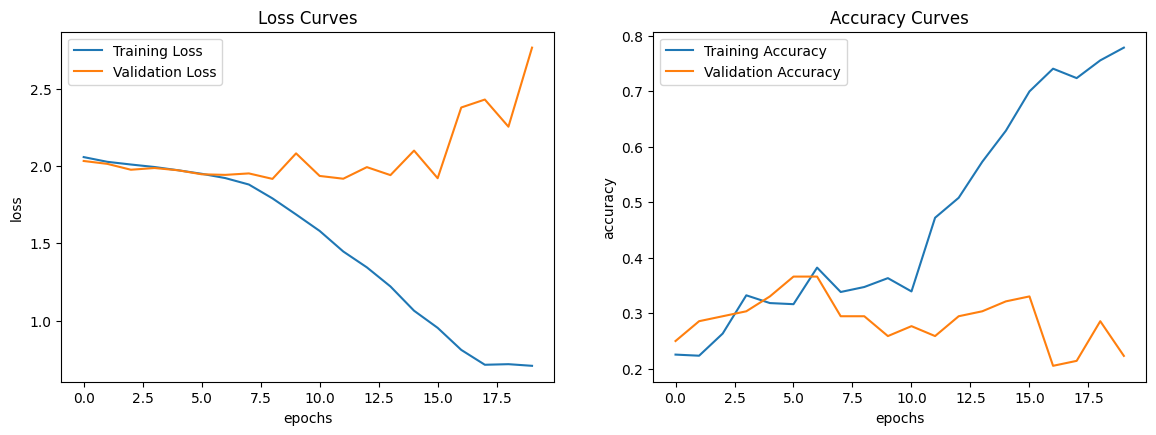

In [8]:
tr_loss = history.history[ 'loss']
val_loss = history.history['val_loss']
tr_acc = history.history[ 'accuracy']
val_acc = history.history[ 'val_accuracy']
epochs = range(len(tr_loss)) # get the epochs as a list to plot along the x-axis

plt.figure(figsize=(14,10))
# Loss curves
ax = plt.subplot(2,2,1)
plt.plot(epochs, tr_loss, label='Training Loss') 
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curves')
plt.legend()
# Accuracy curves
ax = plt.subplot(2,2,2)
plt.plot(epochs, tr_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Curves')
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
              precision    recall  f1-score   support

       trust       0.21      0.13      0.16        23
     disgust       0.33      0.45      0.38        20
anticipation       0.19      0.12      0.15        25
     sadness       0.20      0.25      0.22         4
       anger       0.43      0.30      0.35        10
        fear       0.10      0.21      0.14        14
    surprise       0.14      0.11      0.12         9
         joy       0.29      0.29      0.29         7

    accuracy                           0.22       112
   macro avg       0.24      0.23      0.23       112
weighted avg       0.23      0.22      0.22       112



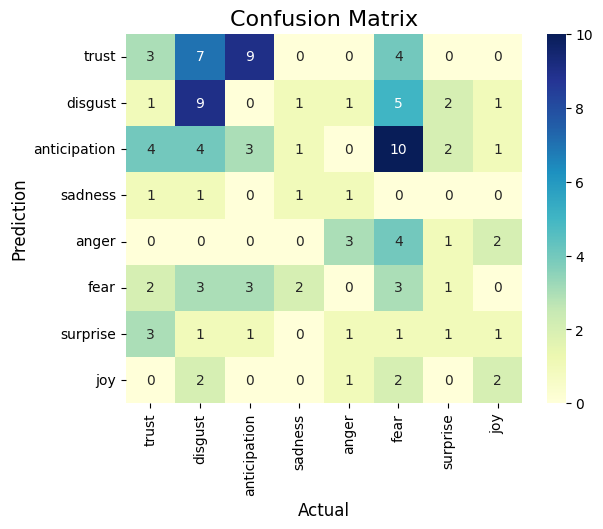

In [10]:
X_text = np.asarray(processed_data['padded'].to_list())
X_sarcasm = processed_data['Sarcasm'].values.reshape(-1, 1)
X_irony = processed_data['Irony'].values.reshape(-1, 1)
X_negation = processed_data['Negation'].values.reshape(-1, 1)
X_sentiment_polarity = OneHotEncoder().fit_transform(processed_data[['Sentiment Polarity']]).toarray()
# X_sentiment_polarity = OneHotEncoder().fit_transform(df[['Sentiment Polarity']])
y = pd.get_dummies(processed_data['Emotion']).values

X_text_train, X_text_val, X_sarcasm_train, X_sarcasm_val, X_irony_train, X_irony_val, X_negation_train, X_negation_val, X_sentiment_polarity_train, X_sentiment_polarity_val, y_train, y_val = train_test_split(
        X_text, X_sarcasm, X_irony, X_negation, X_sentiment_polarity, y, test_size=0.1, random_state=42, stratify=y
    )

labels = processed_data["Emotion"].unique().tolist()

y_pred = model.predict([X_text_val, X_sarcasm_val, X_irony_val, X_negation_val, X_sentiment_polarity_val])

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_val, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))

cm = confusion_matrix(Y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()